In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
import time

In [3]:
def parse_attack_types(filename):
    """
    Generate a mapping that looks like:

    {
        'teardrop': {
            'encoding': 0,
            'category': 'dos'
        },
        'smurf': {
            'encoding': 1,
            'category': 'dos'
        },
        ...
    }

    The 'encoding' becomes important in some learning algorithms. We have to encode text
    into numbers so some algorithms can process them.
    """
    attack_map = {}
    attack_encoding = {}
    count = 0
    with open(filename) as f:
        lines = f.readlines()
    for line in lines:
        attack, category = line.split()
        if attack not in attack_map:
            attack_map[attack] = {
                'encoding': count,
                'category': category
            }
            count += 1
    return attack_map


def encode_data(train_data, cols):
    """
    Encode any strings in the training data so that they are integers.
    Also return the map of encodings.
    """
    
    """ Fulbert -- Change the funciton a bit, so cols is a parameter """
    encodings = {}
    for col in cols:
        unique_values = train_data[col].unique()
        mapping = {}
        reverse_mapping = {}  # Used for lookup later if we need it
        for j, value in enumerate(unique_values):
            mapping[value] = j
            reverse_mapping[j] = value
        # Encode strings like ('tcp', 'udp', 'icmp') into (0, 1, 2)
        train_data[col] = train_data[col].map(mapping)
        encodings[col] = reverse_mapping
    return encodings


def parse_data(filename):
    return pd.read_csv(filename, header=None)

In [4]:
print('Running project')
attack_map = parse_attack_types('dataset/attack_types.txt')
print('Attack mapping:')
print(attack_map)
train_data = parse_data('dataset/kddcup.data_10_percent')
print('Raw data:')
print(train_data[:2])
## See labeled data distribution
encodings = encode_data(train_data, (1, 2, 3))
print('Encoded data:')
print(train_data[:2])
print('Encodings:')
print(encodings)

Running project
Attack mapping:
{'back': {'encoding': 0, 'category': 'dos'}, 'buffer_overflow': {'encoding': 1, 'category': 'u2r'}, 'ftp_write': {'encoding': 2, 'category': 'r2l'}, 'guess_passwd': {'encoding': 3, 'category': 'r2l'}, 'imap': {'encoding': 4, 'category': 'r2l'}, 'ipsweep': {'encoding': 5, 'category': 'probe'}, 'land': {'encoding': 6, 'category': 'dos'}, 'loadmodule': {'encoding': 7, 'category': 'u2r'}, 'multihop': {'encoding': 8, 'category': 'r2l'}, 'neptune': {'encoding': 9, 'category': 'dos'}, 'nmap': {'encoding': 10, 'category': 'probe'}, 'perl': {'encoding': 11, 'category': 'u2r'}, 'phf': {'encoding': 12, 'category': 'r2l'}, 'pod': {'encoding': 13, 'category': 'dos'}, 'portsweep': {'encoding': 14, 'category': 'probe'}, 'rootkit': {'encoding': 15, 'category': 'u2r'}, 'satan': {'encoding': 16, 'category': 'probe'}, 'smurf': {'encoding': 17, 'category': 'dos'}, 'spy': {'encoding': 18, 'category': 'r2l'}, 'teardrop': {'encoding': 19, 'category': 'dos'}, 'warezclient': {'e

smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: 41, dtype: int64

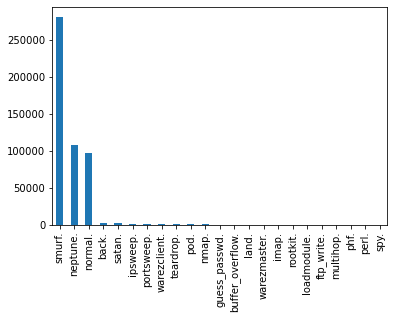

In [5]:
## Plot frequency of each labels
train_data[41].value_counts().plot(kind='bar')
train_data[41].value_counts()

In [6]:
'''Describe Data using Panda Describe for 10%''' 
train_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
count,494021.000000,494021.000000,494021.000000,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,...,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,47.979302,1.189338,8.392376,0.835960,3.025610e+03,8.685324e+02,0.000045,0.006433,0.000014,0.034519,...,232.470778,188.665670,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,0.058118,0.057412
std,707.746472,0.960704,4.973796,1.579212,9.882181e+05,3.304000e+04,0.006673,0.134805,0.005510,0.782103,...,64.745380,106.040437,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,0.230590,0.230140
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,9.000000,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.000000,9.000000,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.000000,10.000000,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,2.000000,65.000000,10.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
'''Display Correlation Matrix 10%, 
the column we are interested is column 41 which is the label '''  
train_data.corr()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,1.000000,-0.023715,0.027185,-0.006068,0.004258,0.005440,-0.000452,-0.003235,0.003786,0.013213,...,0.010074,-0.117515,-0.118458,0.406233,0.042642,-0.006983,-0.030400,-0.030612,0.006739,0.010465
1,-0.023715,1.000000,0.167669,-0.655333,-0.002664,-0.032433,-0.008262,-0.005357,-0.003183,-0.054640,...,0.385535,0.711421,0.692295,-0.260154,0.956481,-0.117590,-0.574551,-0.573439,-0.309225,-0.308833
2,0.027185,0.167669,1.000000,0.349884,-0.001548,-0.025936,-0.008394,0.023455,0.002456,-0.034878,...,0.471978,-0.356139,-0.389429,0.127603,0.127539,-0.173734,0.334510,0.334999,0.059593,0.061795
3,-0.006068,-0.655333,0.349884,1.000000,0.003872,-0.013470,0.013371,-0.025261,-0.001361,-0.021159,...,0.124742,-0.859183,-0.879532,0.256300,-0.635473,-0.029200,0.928322,0.928893,0.210140,0.211055
4,0.004258,-0.002664,-0.001548,0.003872,1.000000,-0.000002,-0.000020,-0.000139,-0.000005,0.004483,...,-0.001743,-0.003212,-0.002052,0.000578,-0.000724,0.001186,-0.000718,0.001122,-0.000393,0.001328
5,0.005440,-0.032433,-0.025936,-0.013470,-0.000002,1.000000,-0.000175,-0.001254,0.016288,0.004365,...,-0.048869,-0.005850,0.007058,-0.005314,-0.020143,0.008707,-0.011334,-0.011235,-0.005000,-0.005471
6,-0.000452,-0.008262,-0.008394,0.013371,-0.000020,-0.000175,1.000000,-0.000318,-0.000017,-0.000295,...,-0.023671,-0.011587,0.001984,-0.000333,0.003799,0.083320,0.012658,0.007795,-0.001511,-0.001665
7,-0.003235,-0.005357,0.023455,-0.025261,-0.000139,-0.001254,-0.000318,1.000000,-0.000123,-0.002106,...,-0.005191,-0.058624,-0.054903,0.071857,-0.031803,0.012092,-0.019091,-0.022104,0.029774,-0.011904
8,0.003786,-0.003183,0.002456,-0.001361,-0.000005,0.016288,-0.000017,-0.000123,1.000000,0.000356,...,-0.007139,-0.004540,-0.003279,0.010536,-0.002002,-0.000408,-0.001194,-0.001191,-0.000648,-0.000641
9,0.013213,-0.054640,-0.034878,-0.021159,0.004483,0.004365,-0.000295,-0.002106,0.000356,1.000000,...,-0.026366,-0.038730,-0.029117,0.001319,-0.052923,-0.004467,-0.019491,-0.020201,-0.006541,-0.007749


In [8]:
"""Try different attack mapping
        normal = 0  
        dos = 1
        probe = 2 
        r2l = 3 
        u2r = 4 
        
        We will end up with 5 classes instead of 23 classes
        
        One thing to note when mapping the 5 classes, there is a period at the end of the 
        label on the original file!!! Don't forget about that. 
"""

def revised_attack_mapping(attack_map):
    revised_attack_map = {}
    for name, value in attack_map.items():
        revised_attack_map[name + "."] = (value['category']) #Don't forget about the period at the end!!
    return revised_attack_map

def attack_category_encoding():
    """
        normal = 0  
        dos = 1
        probe = 2 
        r2l = 3 
        u2r = 4 
    """    
    attack_category_map = {}
    attack_category_map ['normal'] = 0
    attack_category_map ['dos'] = 1
    attack_category_map ['probe'] = 2
    attack_category_map ['r2l'] = 3
    attack_category_map ['u2r'] = 4
    return attack_category_map

category_attack_map = revised_attack_mapping(attack_map)
category_attack_map['normal.'] = "normal" #Removing the period at the end!!

In [9]:
category_attack_map

{'back.': 'dos',
 'buffer_overflow.': 'u2r',
 'ftp_write.': 'r2l',
 'guess_passwd.': 'r2l',
 'imap.': 'r2l',
 'ipsweep.': 'probe',
 'land.': 'dos',
 'loadmodule.': 'u2r',
 'multihop.': 'r2l',
 'neptune.': 'dos',
 'nmap.': 'probe',
 'perl.': 'u2r',
 'phf.': 'r2l',
 'pod.': 'dos',
 'portsweep.': 'probe',
 'rootkit.': 'u2r',
 'satan.': 'probe',
 'smurf.': 'dos',
 'spy.': 'r2l',
 'teardrop.': 'dos',
 'warezclient.': 'r2l',
 'warezmaster.': 'r2l',
 'normal.': 'normal'}

In [10]:
attack_category_map = attack_category_encoding()
attack_category_map

{'normal': 0, 'dos': 1, 'probe': 2, 'r2l': 3, 'u2r': 4}

dos       391458
normal     97278
probe       4107
r2l         1126
u2r           52
Name: 41, dtype: int64

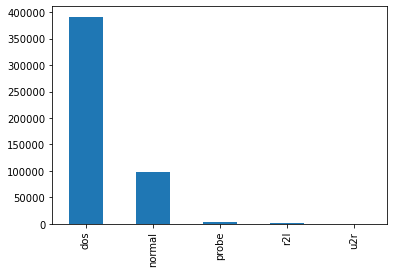

In [11]:
## Map 10% Dataset
train_data[41] = train_data[41].map(category_attack_map)
train_data[41].value_counts().plot(kind='bar')
train_data[41].value_counts()

In [12]:
print(train_data[41].value_counts())

dos       391458
normal     97278
probe       4107
r2l         1126
u2r           52
Name: 41, dtype: int64


In [13]:
## Method to test sklearn classifier
def test_classifier(clf):
    start = time.time()
    clf = clf.fit(X_train, y_train)
    training_ends = time.time()
    prediction = clf.predict(X_test)
    prediction_ends = time.time()
    result = (metrics.classification_report(y_test, prediction, output_dict = True))
    training_time = training_ends - start
    testing_time = prediction_ends - training_ends
    print (metrics.classification_report(y_test, prediction))
    acc = metrics.accuracy_score(y_test, prediction)
    print ("Accuracy Score: %s" % acc)
    print ("Classifier Training time = %s" % training_time)
    print ("Classifier Prediction time = %s" % testing_time)
    train_time.append(training_time)
    test_time.append(testing_time)
    accuracy.append(acc)
    return clf, result


In [14]:
## Split train and test set 
X = train_data.drop(columns=[41])
y = train_data[[41]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=15)
algorithm= []
train_time = []
test_time = []
accuracy = []

In [15]:
## Multinomial Naive Bayes Classifier
clf_MultinomialNB = MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
clf_MultinomialNB, mreport= test_classifier(clf_MultinomialNB)
algorithm.append("MultinomialNB")
## Bernoulli Naive Bayes Classifier
clf_BernoulliNB = BernoulliNB(alpha=0.01, class_prior=None, fit_prior=True)
clf_BernoulliNB, breport = test_classifier(clf_BernoulliNB)
algorithm.append("BernoulliNB")
## Complement Naive Bayes Classifier
clf_ComplementNB = ComplementNB(alpha=0.01, class_prior=None, fit_prior=True)
clf_ComplementNB, creport = test_classifier(clf_ComplementNB)
algorithm.append("ComplementNB")
## Linear SVC Classifier
clf_LinearSVC = LinearSVC(random_state=0, tol=1e-5)
clf_LinearSVC, lreport= test_classifier(clf_LinearSVC)
algorithm.append("LinearSVC")
## Decision Tree Classifier
clf_DecisionTree = DecisionTreeClassifier()
clf_LinearSVC, treereport = test_classifier(clf_DecisionTree)
algorithm.append("DecisionTree")

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

         dos       0.93      0.99      0.96    117444
      normal       0.99      0.55      0.71     29172
       probe       0.00      0.00      0.00      1264
         r2l       0.00      0.00      0.00       310
         u2r       0.00      0.53      0.00        17

    accuracy                           0.90    148207
   macro avg       0.39      0.42      0.34    148207
weighted avg       0.93      0.90      0.90    148207

Accuracy Score: 0.8965973267119637
Classifier Training time = 2.486454963684082
Classifier Prediction time = 0.08181619644165039


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

         dos       0.98      0.94      0.96    117444
      normal       0.95      0.89      0.92     29172
       probe       0.08      0.60      0.15      1264
         r2l       0.44      0.42      0.43       310
         u2r       0.58      0.65      0.61        17

    accuracy                           0.92    148207
   macro avg       0.61      0.70      0.61    148207
weighted avg       0.97      0.92      0.94    148207

Accuracy Score: 0.9240454229557309
Classifier Training time = 1.759850263595581
Classifier Prediction time = 0.19504046440124512


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarnin

              precision    recall  f1-score   support

         dos       0.92      0.99      0.95    117444
      normal       0.99      0.63      0.77     29172
       probe       0.00      0.00      0.00      1264
         r2l       0.00      0.00      0.00       310
         u2r       0.00      0.00      0.00        17

    accuracy                           0.91    148207
   macro avg       0.38      0.33      0.35    148207
weighted avg       0.92      0.91      0.91    148207

Accuracy Score: 0.9120351940191759
Classifier Training time = 1.3722248077392578
Classifier Prediction time = 0.03125762939453125


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

         dos       0.99      1.00      1.00    117444
      normal       0.99      0.93      0.96     29172
       probe       0.75      0.92      0.83      1264
         r2l       0.22      0.88      0.36       310
         u2r       0.08      0.06      0.07        17

    accuracy                           0.99    148207
   macro avg       0.61      0.76      0.64    148207
weighted avg       0.99      0.99      0.99    148207

Accuracy Score: 0.9857496609471887
Classifier Training time = 332.6174592971802
Classifier Prediction time = 0.062468767166137695
              precision    recall  f1-score   support

         dos       1.00      1.00      1.00    117444
      normal       1.00      1.00      1.00     29172
       probe       0.99      0.99      0.99      1264
         r2l       0.93      0.97      0.95       310
         u2r       0.79      0.65      0.71        17

    accuracy                           1.00    148207
 

In [16]:
"""
    normal = 0  
    dos = 1
    probe = 2 
    r2l = 3 
    u2r = 4 
"""    

def extract_algorithm_result (report):
    result = []
    getresult_inlist(report, 'normal', result)
    getresult_inlist(report, 'dos', result)
    getresult_inlist(report, 'probe', result)
    getresult_inlist(report, 'r2l', result)
    getresult_inlist(report, 'u2r', result)
    return result
def getresult_inlist (report, label, resultlist):
    for index in report[label]:
        resultlist.append(report[label][index])
         # Precision, recall, f1-score, support
    

In [17]:
def plot_algorithm_result(report, title):
    #indexes = [0,1,2,4,5,6,8,9,10,12,13,14,16,17,18]
    result = extract_algorithm_result(report)
    ## Plot Precision
    indexes = [0,4,8,12,16]
    algorithm_title = ("Precision %s" % title)
    plot_metric(result, indexes, algorithm_title)
        
    ## Plot Recall
    indexes = [1,5,9,13,17]
    algorithm_title = ("Recall %s" % title)
    plot_metric(result, indexes, algorithm_title)
    
    ## Plot f1-score
    indexes = [2,6,10,14,18]
    algorithm_title = ("F1-Score of %s" % title)
    plot_metric(result, indexes, algorithm_title)
        
    ## Plot Support
    indexes = [3,7,11,15,19]
    algorithm_title = ("Support %s" % title)
    plot_support(result, indexes, algorithm_title) # Note this one is a different function

def plot_metric(result, indexes, algorithm_title):
    fig, ax = plt.subplots()
    Yval = [result[x] * 100 for x in indexes]
    Xval = np.linspace(1,7,5)
    barlist = plt.bar(Xval,Yval)
    barlist[0].set_color('g')
    barlist[1].set_color('r')
    barlist[2].set_color('magenta')
    barlist[3].set_color('yellow')
    barlist[4].set_color('darkblue')
    plt.suptitle(algorithm_title)
    plt.legend((barlist[0], barlist[1], barlist[2], barlist[3], barlist[4]),('normal', 'dos', 'probe', 'r2l', 'u2r' ), loc='best')

def plot_support(result, indexes, algorithm_title):
    fig, ax = plt.subplots()
    Yval = [result[x] for x in indexes]
    Xval = np.linspace(1,7,5)
    barlist = plt.bar(Xval,Yval)
    barlist[0].set_color('g')
    barlist[1].set_color('r')
    barlist[2].set_color('magenta')
    barlist[3].set_color('yellow')
    barlist[4].set_color('darkblue')
    plt.suptitle(algorithm_title)
    plt.legend((barlist[0], barlist[1], barlist[2], barlist[3], barlist[4]),('normal', 'dos', 'probe', 'r2l', 'u2r' ), loc='best')

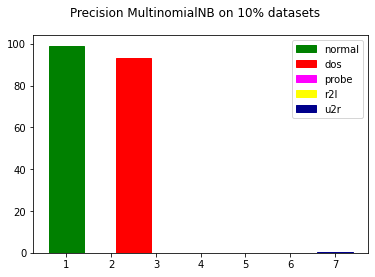

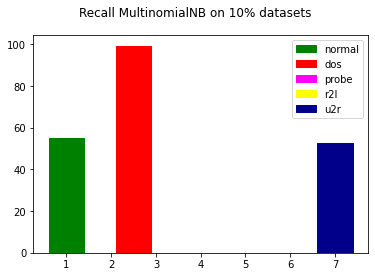

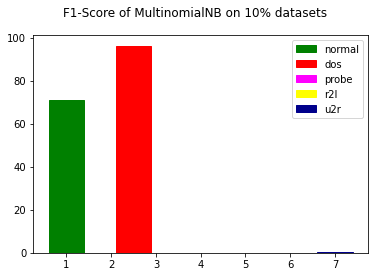

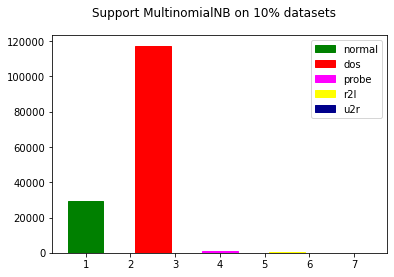

In [18]:
## Plot MultinomialNB Result 
plot_algorithm_result(mreport, "MultinomialNB on 10% datasets")

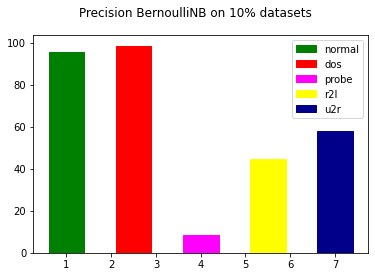

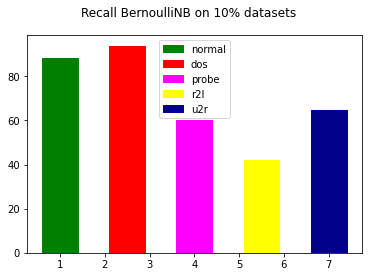

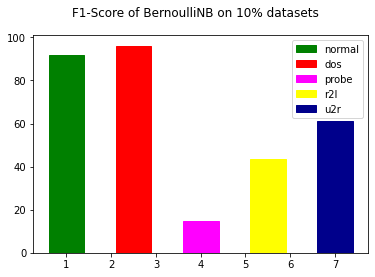

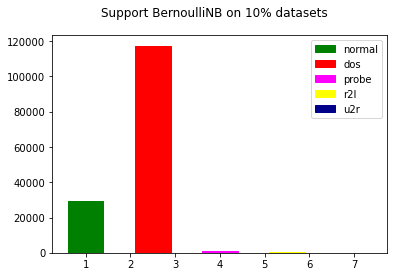

In [19]:
## Plot BernoulliNB Result 
plot_algorithm_result(breport, "BernoulliNB on 10% datasets")

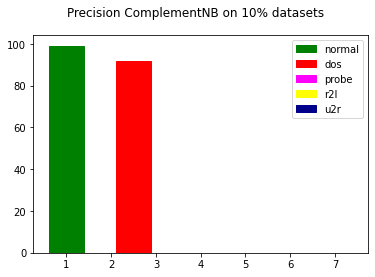

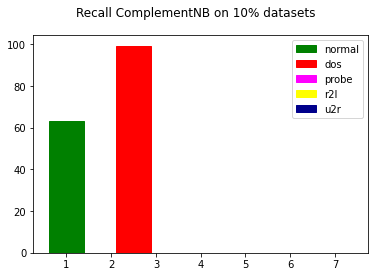

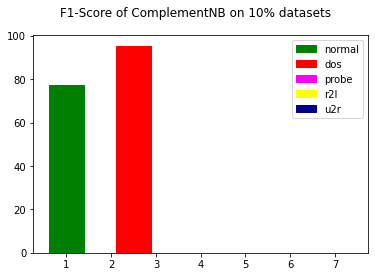

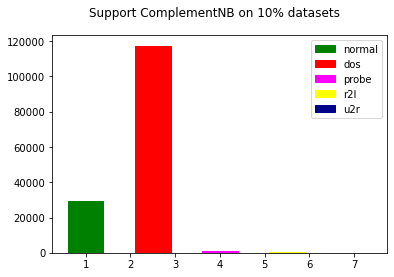

In [20]:
## Plot ComplementNB Result 
plot_algorithm_result(creport, "ComplementNB on 10% datasets")


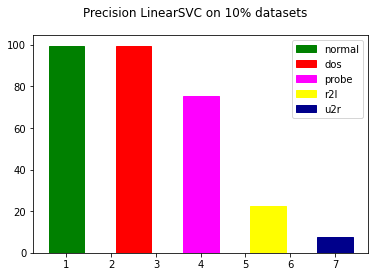

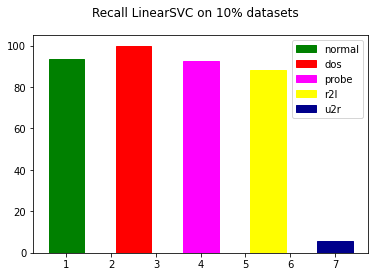

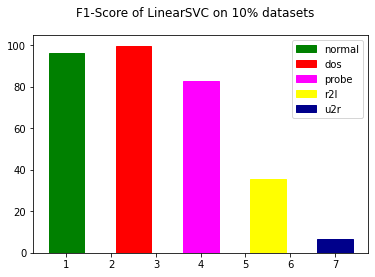

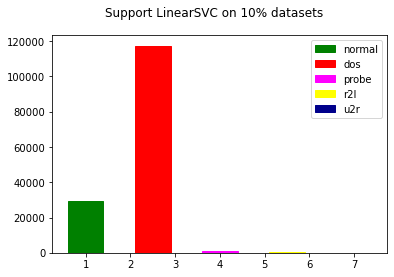

In [21]:
## Plot LinearSVC Result 
plot_algorithm_result(lreport, "LinearSVC on 10% datasets")


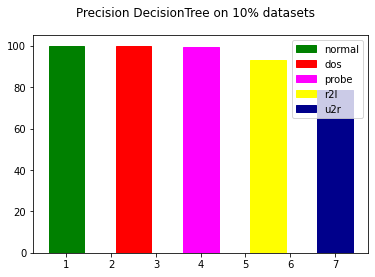

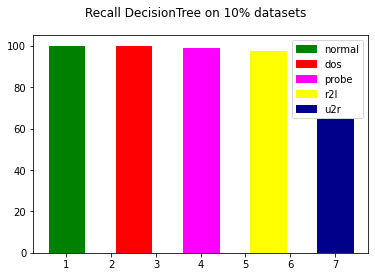

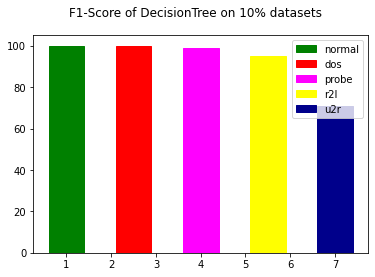

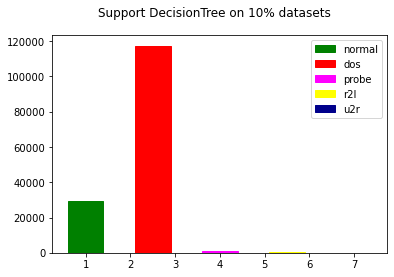

In [22]:
## Plot DecisionTree Result 
plot_algorithm_result(treereport, "DecisionTree on 10% datasets")

In [23]:
## Load full dataset. Plot and print frequency of each class in the full dataset
train_data_2 = parse_data('./dataset/kddcup.data.corrected')
train_data_2.head()
encodings = encode_data(train_data_2, (1, 2, 3))
train_data_2[41].value_counts().plot(kind='bar')
train_data_2[41].value_counts()
algorithm_10 = algorithm
train_time_10 = train_time
test_time_10 = test_time
accuracy_10 = accuracy
algorithm= []
train_time = []
test_time = []
accuracy = []

FileNotFoundError: [Errno 2] No such file or directory: './dataset/kddcup.data.corrected'

In [ ]:
## Plot and print frequency of each class after mapping
train_data_2[41] = train_data_2[41].map(category_attack_map)
train_data_2[41].value_counts().plot(kind='bar')
train_data_2[41].value_counts()

In [ ]:
#train_data_2[41] = train_data_2[41].map(attack_category_encoding())
#train_data_2[41].value_counts().plot(kind='bar')

In [ ]:
'''Describe Data using Panda Describe for 100%''' 
train_data_2.describe()

In [ ]:
'''Display Correlation Matrix 100%, 
the column we are interested is column 41 which is the label '''  
train_data_2.corr()

In [ ]:
X = train_data_2.drop(columns=[41])
y = train_data_2[[41]]
#X = X.drop(columns=[19])
#X = X.drop(columns=[20])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=15)

In [ ]:
## Bernoulli Naive Bayes Classifier
clf_BernoulliNB = BernoulliNB(alpha=0.01, class_prior=None, fit_prior=True)
clf_BernoulliNB, breport= test_classifier(clf_BernoulliNB)
plot_algorithm_result(breport, "BernoulliNB on 100% datasets")

In [ ]:
## Decision Tree Classifier
clf_DecisionTree = DecisionTreeClassifier()
clf_DecisionTree, treereport = test_classifier(clf_DecisionTree)
plot_algorithm_result(treereport, "DecisionTree on 100% datasets")

In [ ]:
def tune_classifier(clf):
    start = time.time()
    clf = clf.fit(X_train, y_train)
    training_ends = time.time()
    prediction = clf.predict(X_test)
    prediction_ends = time.time()
    temp = (metrics.classification_report(y_test, prediction, output_dict = True))
    result = result['u2r']
    training_time = training_ends - start
    testing_time = prediction_ends - training_ends
    print (metrics.classification_report(y_test, prediction))
    acc = metrics.accuracy_score(y_test, prediction)
    print ("Accuracy Score: %s" % acc)
    print ("Classifier Training time = %s" % training_time)
    print ("Classifier Prediction time = %s" % testing_time)
    return clf, result

In [ ]:
## Decision Tree Classifier Parameter tuning
clf_DecisionTree = DecisionTreeClassifier(criterion = 'entropy')
clf_DecisionTree = test_classifier(clf_DecisionTree)

In [ ]:
clf_DecisionTree = DecisionTreeClassifier(criterion = 'entropy', class_weight = 'balanced')
clf_DecisionTree = test_classifier(clf_DecisionTree)

In [ ]:
weight={}
weight['dos'] = 1
weight['normal'] = 1
weight['probe'] = 1
weight['r2l'] = 1
tree_report_entropy = []
for classweight in range (1, 202, 25):
    weight['u2r'] = classweight
    clf_DecisionTree = DecisionTreeClassifier(criterion = 'entropy', class_weight = weight)
    clf_DecisionTree, report = tune_classifier(clf_DecisionTree)
    tree_report_entropy.append(report)

In [ ]:
def plot_parameter_tuning(report, title):
    fig, ax = plt.subplots()
    precision_list = []
    recall_list = []
    f1_score_list = []    
    for i in range (0,9):
        precision_list.append(tree_report_entropy[i]['u2r']['precision'])
        recall_list.append(tree_report_entropy[i]['u2r']['recall'])
        f1_score_list.append(tree_report_entropy[i]['u2r']['f1-score'])
    X = list(range(1, 202, 25))
    plt.plot(X, precision_list, label = "Precision")
    plt.plot(X, recall_list, label = "Recall")
    plt.plot(X, f1_score_list, label = "f1_score_list")
    plt.xlabel("u2r Weight")
    plt.legend(loc = "best")
    plt.suptitle(title)

In [ ]:
weight={}
weight['dos'] = 1
weight['normal'] = 1
weight['probe'] = 1
weight['r2l'] = 1
tree_report = []
for classweight in range (1, 202, 25):
    weight['u2r'] = classweight
    clf_DecisionTree = DecisionTreeClassifier(class_weight = weight)
    clf_DecisionTree, report = tune_classifier(clf_DecisionTree)
    tree_report.append(report)

In [ ]:
def plot_parameter_tuning(report, title):
    fig, ax = plt.subplots()
    precision_list = []
    recall_list = []
    f1_score_list = []    
    for i in range (0,9):
        precision_list.append(tree_report_entropy[i]['u2r']['precision'])
        recall_list.append(tree_report_entropy[i]['u2r']['recall'])
        f1_score_list.append(tree_report_entropy[i]['u2r']['f1-score'])
    X = list(range(1, 202, 25))
    plt.plot(X, precision_list, label = "Precision")
    plt.plot(X, recall_list, label = "Recall")
    plt.plot(X, f1_score_list, label = "f1_score_list")
    plt.xlabel("u2r Weight")
    plt.legend(loc = "best")
    plt.suptitle(title)
plot_parameter_tuning(tree_report_entropy, 'Decision Tree Parameter Tuning (Entropy Criteria)')
plot_parameter_tuning(tree_report, 'Decision Tree Parameter Tuning (GINI Criteria)')

In [ ]:
## Final Decision Tree Classifier
weight={}
weight['dos'] = 1
weight['normal'] = 1
weight['probe'] = 1
weight['r2l'] = 1
weight['u2r'] = 102
clf_DecisionTree_final = DecisionTreeClassifier(criterion = 'entropy', class_weight = weight)
clf_DecisionTree_final, treereport_final = test_classifier(clf_DecisionTree_final)
## Plot Final DecisionTree Result 
plot_algorithm_result(treereport_final, "Final DecisionTree on 100% datasets")

In [ ]:
## Saving Model
import pickle
pickle.dump(clf_DecisionTree_final, open("DT_model.pkl","wb"))